# **Heart Failure Prediction**
By: Kyle Hostetter

## Data Information

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure. Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies. People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Columns**
* age- The age of the person
* anaemia- Decrease of red blood cells or hemoglobin
* creatinine_phosphokinase- Level of the CPK enzyme in the blood (mcg/L)
* diabetes- If the patient has diabetes
* ejection_fraction- Percentage of blood leaving the heart at each contraction
* high_blood_pressure- If the patient has hypertension
* platelets- Platelets in the blood (kiloplatelets/mL)
* serum_creatinine- Level of serum creatinine in the blood (mg/dL)
* serum_sodium- Level of serum sodium in the blood (mEq/L)
* sex- Woman or man 
* smoking- If the patient smokes or not
* time- Follow-up period (days)
* DEATH_EVENT- If the patient deceased during the follow-up period

## Import Libraries

In [1]:
'''
Title: Heart Failure Prediction System
Author: Kyle Hostetter
Date: 04-02-2023
Description: A simple classifiacation of the Heart Failure. 
'''

# Import Core Libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Metric & Preprocessing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, recall_score
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report

# Import Machine Learning Libraries
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Import Warning Libaries
from warnings import simplefilter

# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)

# Set Theme for graphs
sns.set_theme(palette='bright')

import warnings
warnings.filterwarnings('ignore')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Self-Made Functions

In [2]:
'''
Self Made Functions-
I tend to use this functions alot so I have imported them for easier use. :-)
'''
# IMPORTANCE FUNCTIONS
def treeRegressionImportance(model_name, model, X_train, y_train):
    '''
    Title: Tree Regression Importance
    Description: This will output features of importance in a tree regression model.    
                 Random Forest & Decision Tree Importance.

    model_name: The name of the tree model.
    model: Tree Model
    X_train: X_train dataset.
    y_train: y_train dataset.
    top_values: The top # of features of importance.
    '''
    # Create title for Chart
    title = 'Feature Importance for '+ model_name

    # Fit model
    model.fit(X_train, y_train)

    # Create list to hold features values
    feature_list = []

    # Extract feature names and their importance
    for feature, importance in zip(X_train.columns, model.feature_importances_):  
        temp = [feature, importance]
        feature_list.append(temp)

    # Create Pandas DataFrame
    importance_df= pd.DataFrame(feature_list, columns = ['Feature', 'Importance'])
    importance_df= importance_df.sort_values('Importance', ascending = False)

    # Display Importance DataFrame
    display(importance_df)

    # Create Barchart
    sns.barplot(data=importance_df,
                x='Importance',
                y='Feature',
                orient='h')

    # Title for chart
    plt.title(title)

def logisticRegressionImportance(model, X, X_train, y_train): 
    '''
    Title: Logistic Regression Importance
    Description: This will display the importances of a Logisitic Regression Model.
    
    model: Logistic Regression Model
    X: X features.
    X_train: X_train array.
    y_train: y_train array.
    '''
    # Assign model to variable
    log_model = model

    # Train Machine Learning Model
    log_model.fit(X_train, y_train)
    
    # Importance Information
    results = {
        'Feature': X.columns,
        'Scoring': abs(log_model.coef_[0])
    }
    
    # Put importance info into dataframe
    df_Scores = pd.DataFrame(results)
    
    # Order DataFrame
    df_Scores = df_Scores.sort_values(by='Scoring', ascending=False)
    print(' '*2,'Logisitic Regression Feature Importance')
    print('-'*40)
    display(df_Scores)
    
    # Figure Size
    plt.figure(figsize=(12,8))
    
    # Plot importance of features
    sns.barplot(data=df_Scores, 
                y='Feature', 
                x='Scoring', 
                orient='h')
    
    # Title of figures
    plt.title('Logisitic Regression Feature Importance')

def xgbImportance(model, X, X_train, y_train): 
    '''
    Title: XGB Importance
    Description: This will display the importances of a Logisitic Regression Model.
    
    model: XGB Model
    X: X features.
    X_train: X_train array.
    y_train: y_train array.
    '''
    # Assign model to variable
    xgb_model = model

    # Train Machine Learning Model
    xgb_model.fit(X_train, y_train)
    
    # Importance Information
    results = {
        'Feature': X.columns,
        'Scoring': xgb_model.feature_importances_
    }
    
    # Put importance info into dataframe
    df_Scores = pd.DataFrame(results)
    
    # Order DataFrame
    df_Scores = df_Scores.sort_values(by='Scoring', ascending=False)
    print(' '*2,'XGB Classifer Feature Importances')
    print('-'*40)
    display(df_Scores)
    
    # Figure Size
    plt.figure(figsize=(12,8))
    
    # Plot importance of features
    sns.barplot(data=df_Scores, 
                y='Feature', 
                x='Scoring', 
                orient='h')
    
    # Title of figures
    plt.title('XGB Classifier Feature Importance')


# VISUALIZATION FUNCTIONS
def histogram_boxplot(data, feature, figsize = (12, 7), kde = False):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    """
    # Title of Chart
    title = 'Univariate Analysis of ' + feature

    # Outlier Calculations
    upper_outlier = data[feature].mean() + data[feature].std()*3
    lower_outlier = data[feature].mean() - data[feature].std()*3

    # Structure of Chart
    f2, (ax_box2, ax_hist2) = plt.subplots( nrows = 2,  # Number of rows of the subplot grid = 2
                                            sharex = True,  # x-axis will be shared among all subplots
                                            gridspec_kw = {"height_ratios": (0.25, 0.75)},
                                            figsize = figsize)  # Creating the 2 subplots
    
    # Add title to figure
    plt.suptitle(title) 
    
    # Plot Boxplot 
    sns.boxplot( data = data, 
                 x = feature, 
                 ax = ax_box2, 
                 showmeans = True, 
                 color = "violet")  
    
    # Plot Histogram
    sns.histplot(data = data, 
                 x = feature, 
                 kde = kde, 
                 ax = ax_hist2)
    
    # Add Mean
    ax_hist2.axvline(data[feature].mean(), 
                     color = "green", 
                     linestyle = "--")  
    
    # Add Median
    ax_hist2.axvline(data[feature].median(), 
                     color = "black", 
                     linestyle = "-")  
    
    # Add Upper Outlier
    ax_hist2.axvline(upper_outlier, 
                     color = "red", 
                     linestyle = "-")

    # Add Lower Outlier
    ax_hist2.axvline(lower_outlier, 
                     color = "red", 
                     linestyle = "-")  

def categoricalVisualizations(figsize, title, rows, columns, dataFrame, cat_columns):
  '''
  Title: Categorical Countplot Visualizations
  Description: This is create a figure with subplots for distribution of
               categorical columns.

  figsize= Height and width of figure size.
  title= Title of figure.
  rows= Number of rows in figure.
  columns= Number of columns in figure. 
  dataFrame= DataFrame of values.
  cat_columns= List of categorical columns.
  '''
  # Choose Size of Chart
  plt.figure(figsize=figsize)
  plt.suptitle(title)

  for i in range(0,len(cat_columns)):
    
    # Iterate through subplots
    plt.subplot(rows,columns,i+1)

    # Plot CountPlot
    ax = sns.countplot(data=dataFrame,                                                                    # DataFrame of values
                       x=dataFrame[cat_columns[i]],                                                       # Column Name
                       order=dataFrame[cat_columns[i]].value_counts().sort_values(ascending=True).index)  # Order of values

    # Value coutns for each bar
    abs_values = dataFrame[cat_columns[i]].value_counts(ascending=True).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)

def continuousVisulaizations(figsize, title, rows, columns, dataFrame, con_columns):
  '''
  Title: Continuous Distribution Visualizations
  Description: This is create a figure with subplots for distribution of
               continuous columns.

  figsize= Height and width of figure size.
  title= Title of figure.
  rows= Number of rows in figure.
  columns= Number of columns in figure. 
  dataFrame= DataFrame of values.
  con_columns= List of continuous column names.
  '''
  # Choose Size of Chart
  plt.figure(figsize=figsize)
  plt.suptitle(title)

  for i in range(0,len(con_columns)):

    # Statisical Computations
    mean = dataFrame[con_columns[i]].mean()     # Calculate mean for column
    median = dataFrame[con_columns[i]].median() # Calculate median for column

    # Calculate lower and higher outlier range
    low_outliers = mean - dataFrame[con_columns[i]].std()*3   # Calcualte lower outliers     
    high_outliers = mean + dataFrame[con_columns[i]].std()*3  # Calculate upper ouliers

    # Iterate through subplots
    plt.subplot(rows,columns,i+1)

    # Plot Histograms
    sns.histplot(data=dataFrame,    # DataFrame  
                 x=con_columns[i],  # Column Name
                 kde=True)          # Show KDE Distribution

    # If outliers are below 0 do no show lower outlier line
    if low_outliers > 0:
      plt.axvline(low_outliers, color='r')

    # Plot Statisical Metrics on chart
    plt.axvline(mean, color='g')
    plt.axvline(median, color='orange')
    plt.axvline(high_outliers, color='r')

def precisionRecallAnalysis(y_true, y_proba):
  '''
  Title: Precision & Recall Analysis
  Description: This will produce two charts that to give visualization to 
               precision and recall.
  
  y_true: The true values target values.
  y_proba: The associated probabilies for making predicitons on y_true. 
  '''
  # Precision Recall Analysis 
  precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba[:,1])

  # Set size of graph
  plt.figure(figsize=(16, 7))  
  plt.suptitle('Precision vs. Recall Analysis')

  # Create First plot
  plt.subplot(1,2,1)
  plt.title('Precision & Recall VS. Threshold')
  plt.xlabel("Threshold")
  plt.ylabel('Precision & Recall')
  line1 = sns.lineplot(x = thresholds, y = precisions[:-1], color='b', lw=2)
  line2 = sns.lineplot(x = thresholds , y = recalls[:-1], color='g', lw=2)
  
  # Set Lines to dashes
  line1.lines[0].set_linestyle("--")
  line1.lines[1].set_linestyle("--")
  plt.legend(loc='lower left', labels=['Precision', 'Recall'])

  # Create Presicion VS. Recall Plot
  plt.subplot(1,2,2)
  plt.title('Precision VS. Recall')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  sns.lineplot(x=recalls[:-1], y=precisions[:-1], lw=2)


# MACHINE LEARNING FUNCTIONS
def classifierMetrics(classifiers,classifier_name,X, y, X_train, y_train, X_test, y_test, kfolds):
  import warnings
  warnings.filterwarnings('ignore')
  '''
  Title: Metrics for Classification
  Description: This will perform a varity of Classification Algorithms 
               on the provided datasets. 

  classifiers: Lists of classifiers
  classifier_name: Name of classifiers.
  X: X_dataframe
  y: y_dataframe
  X_train: Array of training features.
  y_train: Array of target values. 
  X_test: Testing feature array for validation.
  y_test: Testing value array for validation.
  '''

  # DataFrame of Trained Results
  test_results = pd.DataFrame()
  cross_results = pd.DataFrame()
  
  # Arrays for Training Results
  test_auc = [] * len(classifiers)
  test_recall = [] * len(classifiers)
  test_accuracy = [] * len(classifiers)
  test_f1_score = [] * len(classifiers)
  test_precision = [] * len(classifiers)

  # Arrays for Test Results
  cross_f1 = [] * len(classifiers)
  cross_auc = [] * len(classifiers)
  cross_recall = [] * len(classifiers)
  cross_accuracy = [] * len(classifiers)
  cross_precision = [] * len(classifiers)

  # Loop through all classifiers and find best performing alogrithm
  for i in range(0,len(classifiers)):

    # Assign and Start time
    trained_model = classifiers[i]   # Assign Model  

    # Train using Cross Validation
    cv_results = cross_validate(classifiers[i],X,y,cv=kfolds, scoring=['accuracy', 'f1','precision', 'recall', 'roc_auc'])

    # Predict Test Data
    trained_model.fit(X_train, y_train)
    y_test_pred = trained_model.predict(X_test)

    # Insert Training Metrics into arrays
    cross_f1.insert(i, cv_results['test_f1'][:-1].mean())
    cross_auc.insert(i, cv_results['test_roc_auc'][:-1].mean())
    cross_recall.insert(i, cv_results['test_recall'][:-1].mean())
    cross_accuracy.insert(i, cv_results['test_accuracy'][:-1].mean())
    cross_precision.insert(i, cv_results['test_precision'][:-1].mean())

    # Insert Testing Metrics into arrys
    test_auc.insert(i, roc_auc_score(y_test, y_test_pred))
    test_recall.insert(i, recall_score(y_test, y_test_pred))
    test_accuracy.insert(i, accuracy_score(y_test, y_test_pred))
    test_f1_score.insert(i, f1_score(y_test, y_test_pred))
    test_precision.insert(i, precision_score(y_test, y_test_pred))

  # Add data into Training DataFrame
  cross_results['Model'] = np.array(classifier_name)
  cross_results['Recall'] = np.array(cross_recall)
  cross_results['Precision'] = np.array(cross_precision)
  cross_results['AUC'] = np.array(cross_auc)
  cross_results['F1_Score'] = np.array(cross_f1)
  cross_results['Accuracy'] = np.array(cross_accuracy)

  # Add data into Testing DataFrame 
  test_results['Model'] = np.array(classifier_name)
  test_results['Recall'] = np.array(test_recall)
  test_results['Precision'] = np.array(test_precision)
  test_results['AUC'] = np.array(test_auc)
  test_results['F1_Score'] = np.array(test_f1_score)
  test_results['Accuracy'] = np.array(test_accuracy)

  # Order Training Results
  cross_results = cross_results.sort_values(by='F1_Score', ascending=False)

  # Order Testing Results
  test_results = test_results.sort_values(by='F1_Score', ascending=False)

  # Print Results for training
  print('Cross-Validation Metrics')
  display(cross_results)

  # Print Results for Testing 
  print('\n')
  print('Train & Test Metrics')
  display(test_results)

def regressionMetrics(regressors, regressor_name, X, y, X_train, y_train, X_test, y_test, kfolds):
  import warnings
  warnings.filterwarnings('ignore')
  '''
  Description: This will perform a varity of Classification Algorithms 
               on the provided datasets. 
  X: X_dataframe
  y: y_dataframe
  X_train: Array of training features.
  y_train: Array of target values. 
  X_test: Testing feature array for validation.
  y_test: Testing value array for validation.
  '''

  # DataFrame of Trained Results
  test_results = pd.DataFrame()
  cross_results = pd.DataFrame()
  
  # Arrays for Training Results
  test_auc = [] * len(classifiers)
  test_recall = [] * len(classifiers)
  test_accuracy = [] * len(classifiers)
  test_f1_score = [] * len(classifiers)
  test_precision = [] * len(classifiers)

  # Arrays for Test Results
  cross_f1 = [] * len(classifiers)
  cross_auc = [] * len(classifiers)
  cross_recall = [] * len(classifiers)
  cross_accuracy = [] * len(classifiers)
  cross_precision = [] * len(classifiers)

  # Loop through all classifiers and find best performing alogrithm
  for i in range(0,len(classifiers)):

    # Assign and Start time
    trained_model = classifiers[i]   # Assign Model  

    # Train using Cross Validation
    cv_results = cross_validate(classifiers[i],X,y,cv=kfolds, scoring=['accuracy', 'f1','precision', 'recall', 'roc_auc'])

    # Predict Test Data
    trained_model.fit(X_train, y_train)
    y_test_pred = trained_model.predict(X_test)

    # Insert Training Metrics into arrays
    cross_f1.insert(i, cv_results['test_f1'][:-1].mean())
    cross_auc.insert(i, cv_results['test_roc_auc'][:-1].mean())
    cross_recall.insert(i, cv_results['test_recall'][:-1].mean())
    cross_accuracy.insert(i, cv_results['test_accuracy'][:-1].mean())
    cross_precision.insert(i, cv_results['test_precision'][:-1].mean())

    # Insert Testing Metrics into arrys
    test_auc.insert(i, roc_auc_score(y_test, y_test_pred))
    test_recall.insert(i, recall_score(y_test, y_test_pred))
    test_accuracy.insert(i, accuracy_score(y_test, y_test_pred))
    test_f1_score.insert(i, f1_score(y_test, y_test_pred))
    test_precision.insert(i, precision_score(y_test, y_test_pred))

  # Add data into Training DataFrame
  cross_results['Model'] = np.array(classifier_name)
  cross_results['Recall'] = np.array(cross_recall)
  cross_results['Precision'] = np.array(cross_precision)
  cross_results['AUC'] = np.array(cross_auc)
  cross_results['F1_Score'] = np.array(cross_f1)
  cross_results['Accuracy'] = np.array(cross_accuracy)

  # Add data into Testing DataFrame 
  test_results['Model'] = np.array(classifier_name)
  test_results['Recall'] = np.array(test_recall)
  test_results['Precision'] = np.array(test_precision)
  test_results['AUC'] = np.array(test_auc)
  test_results['F1_Score'] = np.array(test_f1_score)
  test_results['Accuracy'] = np.array(test_accuracy)

  # Order Training Results
  cross_results = cross_results.sort_values(by='F1_Score', ascending=False)

  # Order Testing Results
  test_results = test_results.sort_values(by='F1_Score', ascending=False)

  # Print Results for training
  print('Cross-Validation Metrics')
  display(cross_results)

  # Print Results for Testing 
  print('\n')
  print('Train & Test Metrics')
  display(test_results)


# USEFUL FUNCTIONS
def seriesStandardScaler(dataFrame, column):
  '''
  Description: This will standarize and scale the column of a dataframe. 

  dataFrame= The dataframe that this column is found in. 
  column= The column of the dataframe that needs to be standardized and scaled. 
  '''
  # Compute Statistics
  mean = dataFrame[column].mean()
  standard_deviation = dataFrame[column].std()

  # Standardize Column
  dataFrame[column] = (dataFrame[column] - mean) / standard_deviation
  return dataFrame[column]

def infoOut(data):
    '''
    Title: Display Dataframe of df.info
    Description: Display a pandas dataframe of df.info

    data: Pandas dataframe.
    '''
    dfInfo = data.columns.to_frame(name='Column')   # Create dataframe         
    dfInfo['Non-Null Count'] = data.notna().sum()   # Add non-null counts to dataframe
    dfInfo['NULL Count'] = data.isnull().sum()      # Add NULL counts to dataframe        
    dfInfo['Dtype'] = data.dtypes                   # add dtype to dataframe
    dfInfo.reset_index(drop=True,inplace=True)      # Reset index        
    return dfInfo                                   # display info dataframe

def nullValues(data):
    '''
    Title: Display Null values in Pandas Dataframe
    Description: Display a pandas dataframe of Null values for each column
    
    data: Pandas dataframe.
    '''
    display(data.isnull().sum().to_frame().rename(columns = {0:'NULL Amounts'}))

## Data Overview

In [3]:
# Assign CSV to a dataframe 
df = pd.read_csv('HeartData.csv')
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


DataFrame Observations-
* We can see that we have 13 columns here. No data seems to be useless. Nothing we can see right off the bat. This seems like al proper dataset.
* We can also see that this dataset has 299 rows of data as well. 
* After reading the background info about the dataset, we will need to split our dataset into continuous and categorical columns.

#### DataFrame Info

In [4]:
# Show all dataFrame info
# Create a dataframe version of df.info()
infoOut(df)

,Column,Non-Null Count,NULL Count,Dtype
0,age,299,0,float64
1,anaemia,299,0,int64
2,creatinine_phosphokinase,299,0,int64
3,diabetes,299,0,int64
4,ejection_fraction,299,0,int64
5,high_blood_pressure,299,0,int64
6,platelets,299,0,float64
7,serum_creatinine,299,0,float64
8,serum_sodium,299,0,int64
9,sex,299,0,int64


#### Null Values

In [5]:
# NULL Value checks
nullValues(df)

,NULL Amounts
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


NULL Oberservations-
* There are no NULL values in this dataset which is PERFECT!

#### Duplicated Rows

In [6]:
# Duplicate Values
display(df.duplicated().sum())

0

Duplicate Observations-
* There are no duplicated rows in this dataset which is PERFECT!

#### Unique Values

In [7]:
# Print out Categorical Columns
for col in df.columns:

    # If there are more than 2 unique values in that column, skip it
    if len(df[col].unique()) > 2:
        pass
    else: 
        # Display the categorical column and its values.
        display(df[col].value_counts().to_frame())

,count
anaemia,
0,170
1,129


,count
diabetes,
0,174
1,125


,count
high_blood_pressure,
0,194
1,105


,count
sex,
1,194
0,105


,count
smoking,
0,203
1,96


,count
DEATH_EVENT,
0,203
1,96


Unique Value Obeservations-
* We can see that these are going to be the categorical columns. This was inferred by the background information.
* There are a total of 6 categorical columns.

#### Split Columns into Categorical or Continuous Lists

In [8]:
# Categorical Columns
cat_columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 
               'DEATH_EVENT']

# Continuous Columns
con_columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
               'platelets', 'serum_creatinine', 'serum_sodium', 'time']

# Target column
target_column =['DEATH_EVENT']

## Exploritory Data Analysis

### Univariate Analysis

#### Basic Statistics

In [9]:
# Print out basic statistics about dataframe
df[con_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0


Basic Statistics Observations-
* 

#### Continuous Analysis

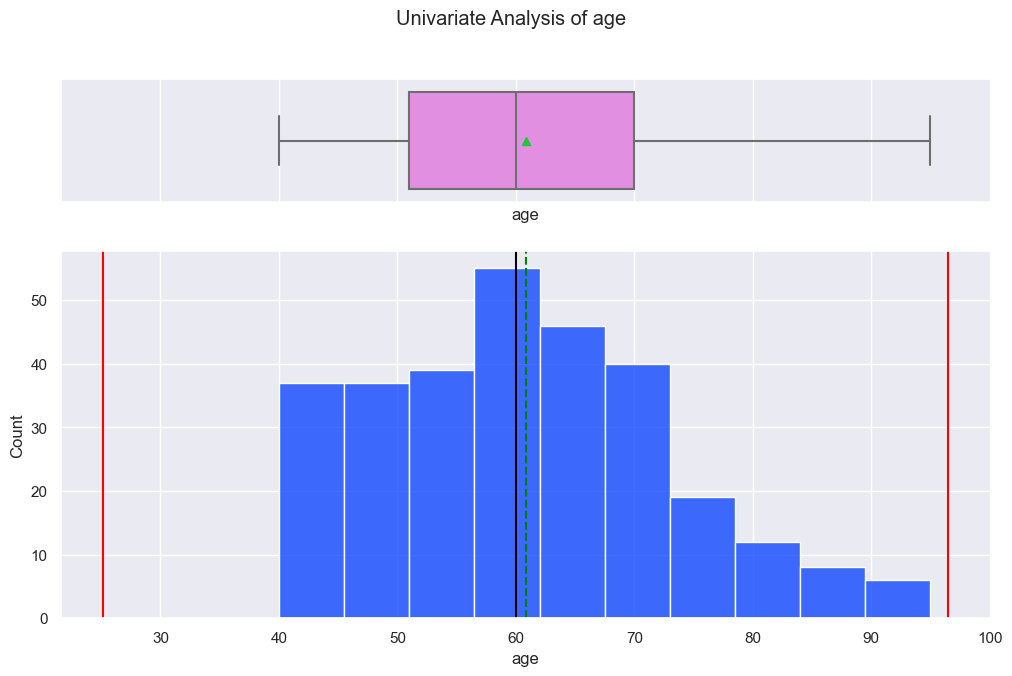

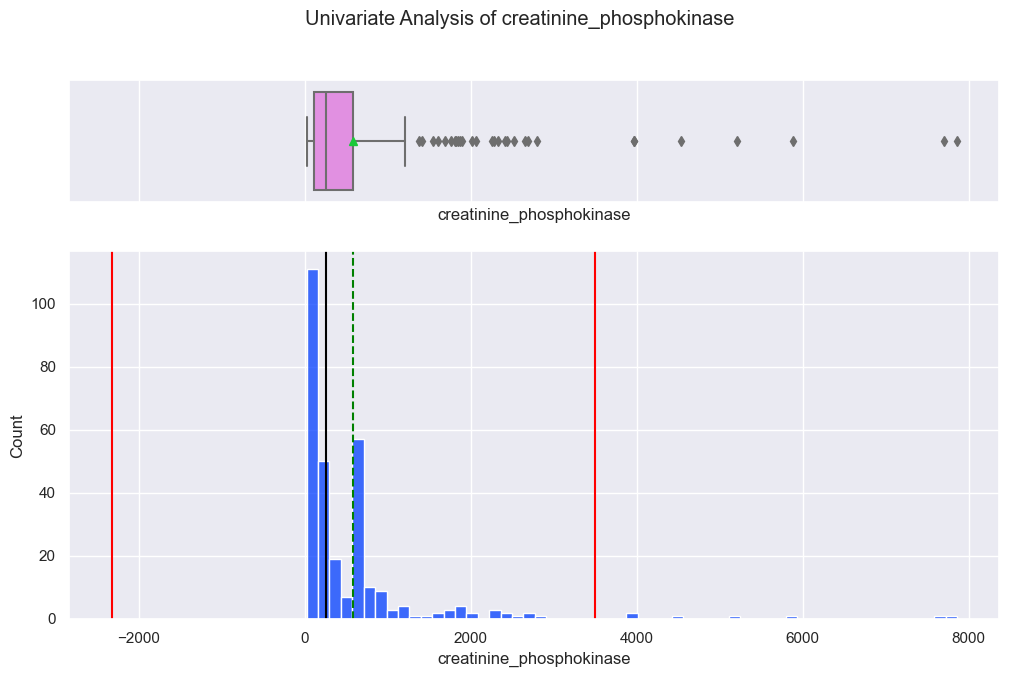

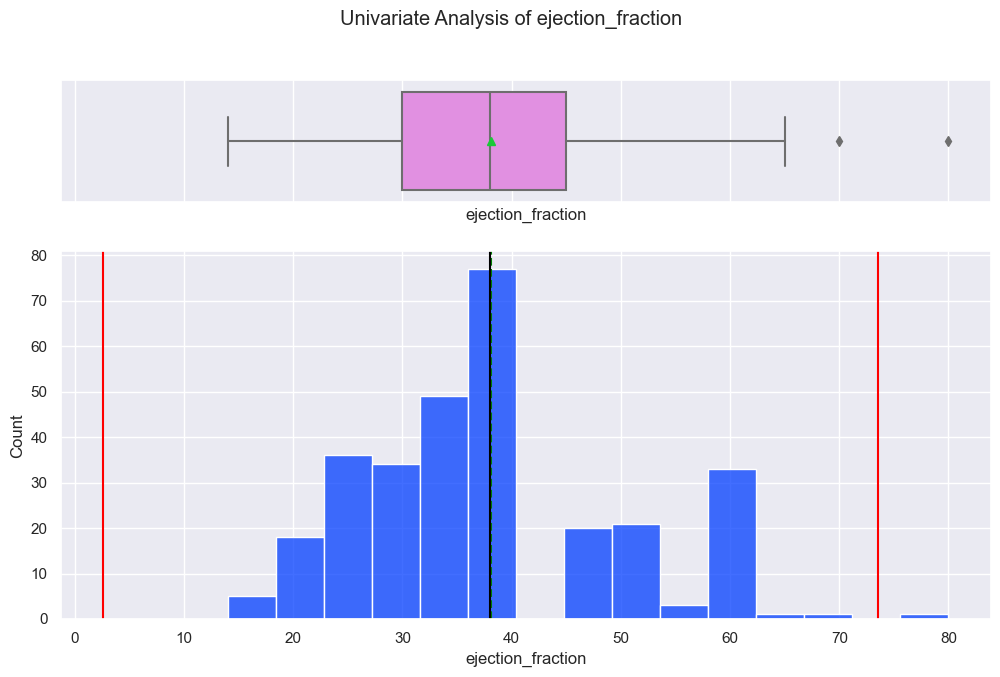

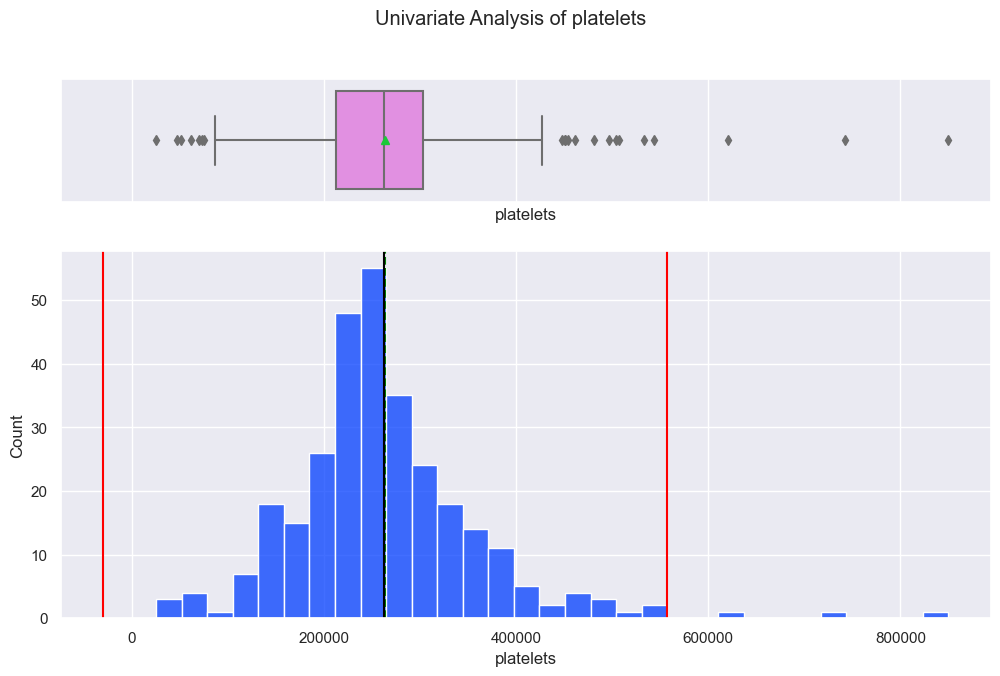

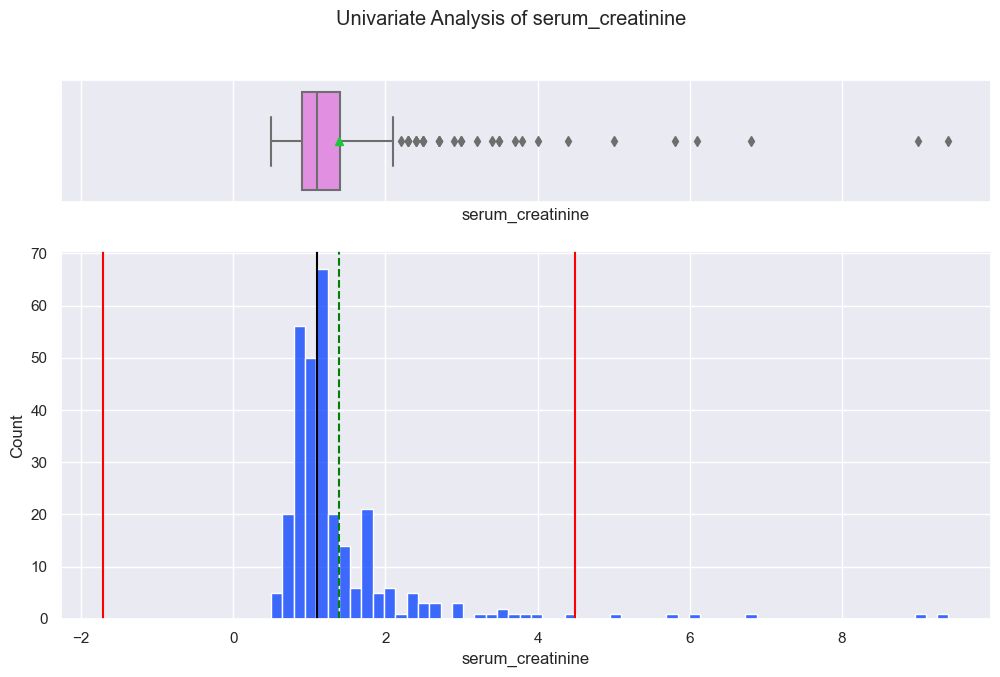

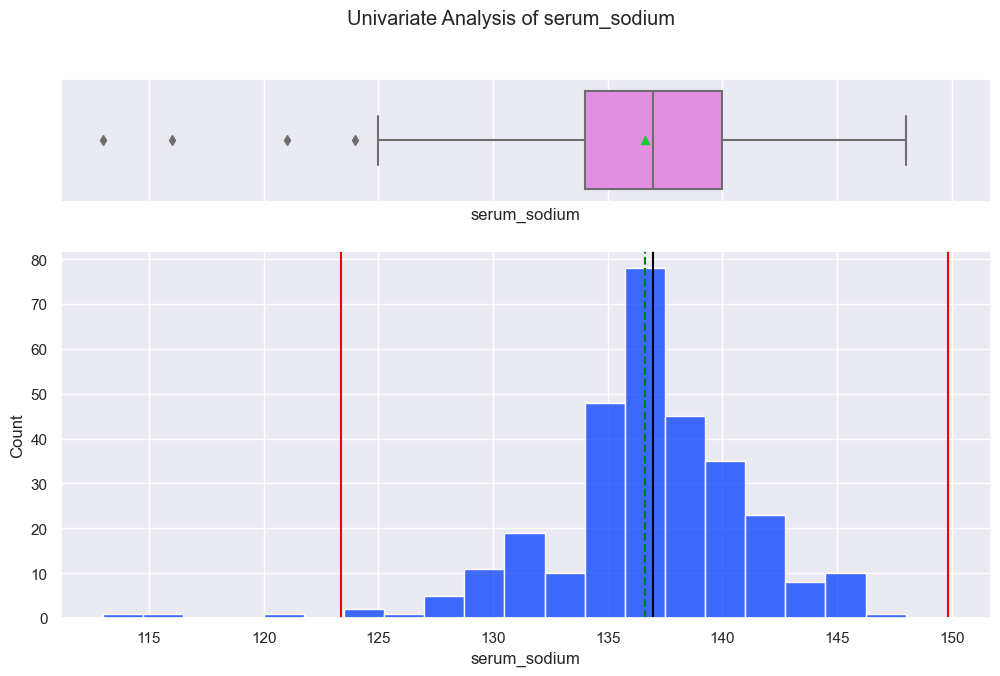

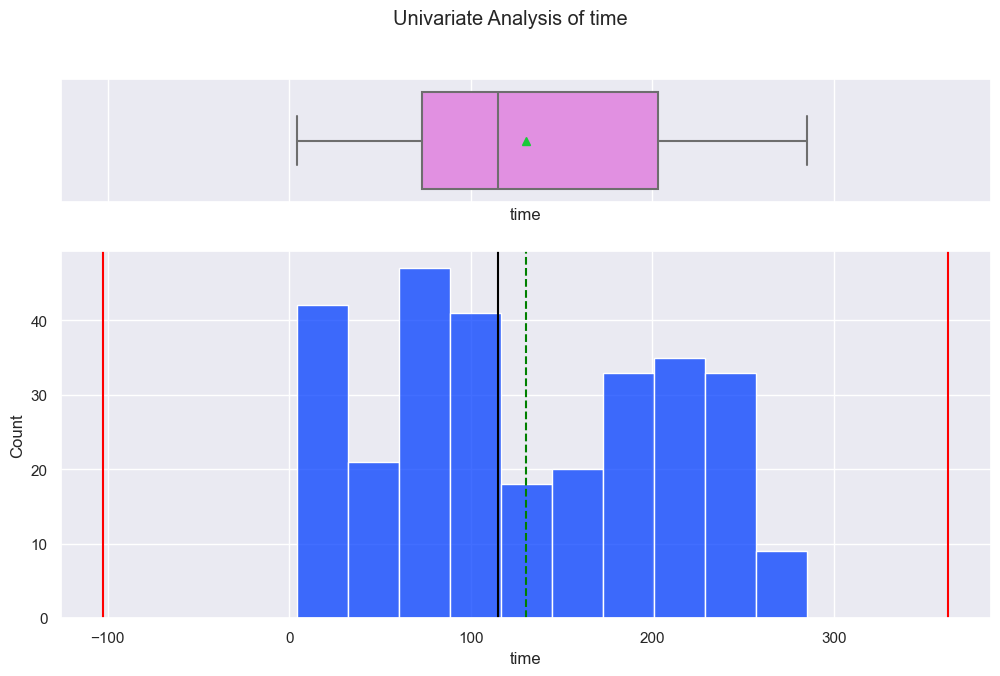

In [10]:
# Show box plots and histograms for all continuous Columns
for col in con_columns:
    # Run the visualization function
    histogram_boxplot(data=df,      # DataFrame
                      feature=col)  # The column the create visualization for

Continuous Column Observations-
* age: 
    - Distribution: Right Skewed
    - Skewness: Slight right
    - Outliers: None
    - Log Transformation Needed: No
<br></br>
* creatinine_phosphokinase: 
    - Distrubtion: Strong right
    - Skewness: Strong right
    - Outliers: A lot, all greater than the mean
    - Log Transformation Needed: Most likely
<br></br>
* ejection_fraction: 
    - Distibution: Somewhat Normal
    - Skewness: Slight right
    - Outliers: 2, all greater than the mean 
    - Log Transformation Needed: None
<br></br>
* platelets: 
    - Distribution: Normal
    - Skewness: None
    - Outliers: Alot, Both sides of the mean
    - Log Transformation Needed: None
<br></br>
* serum_creatinine:
    - Disribution: Skew rith
    - Skewness: Slight right
    - Outliers: Alot, All greater than the mean
    - Log Transformation Needed: Most likely
<br></br>
* serum_sodium: 
    - Distribution: Normal 
    - Skewness: No
    - Outliers: 4, All less than the mean
    - Log Transformation Needed: Nome
<br></br>
* time:
    - Distribution: MultiModal
    - Skewness: None
    - Outliers: None
    - Log Transformation Needed: None

#### Log Transformations

DataFrame with log transformations


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,log_creatinine_phosphokinase,log_serum_creatinine
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,6.366470,0.641854
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,8.969669,0.095310
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,4.983607,0.262364
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,4.709530,0.641854
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,5.075174,0.993252


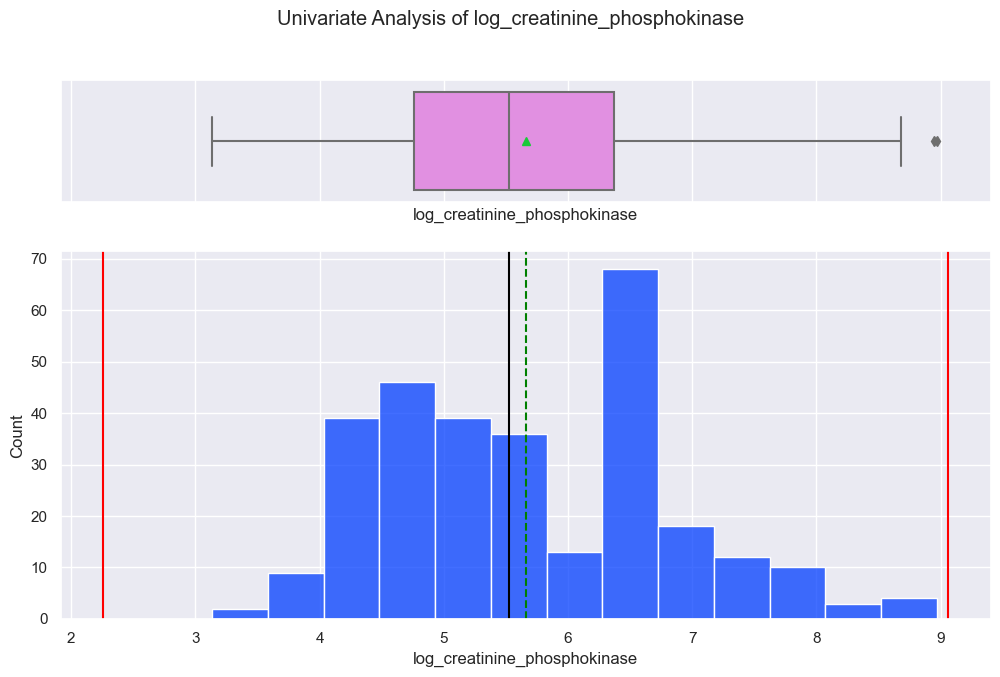

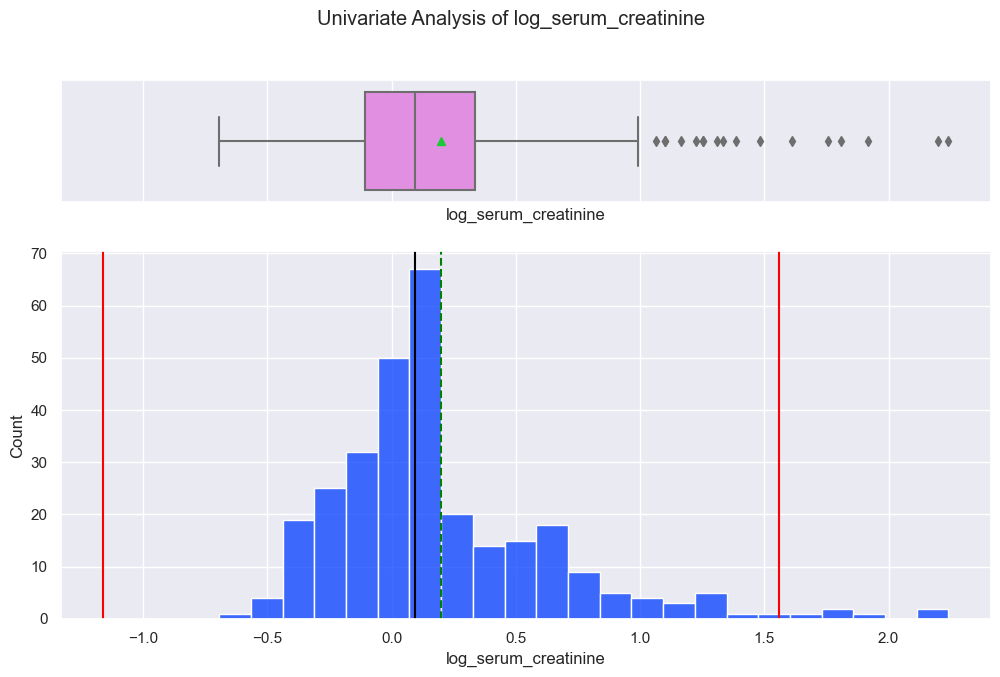

In [11]:
# Create lists of columns that need log transformations
log_columns= ['creatinine_phosphokinase','serum_creatinine']
log_column_names= []

# Create loop to add the log transformations for each column in log_columns
for col in log_columns:
    logged_column_name = 'log_'+ col                # Create a new column for log transformations
    df[logged_column_name] = np.log(df[col])        # Perform the log transformation on column and put it into the dataframe
    log_column_names.append(logged_column_name)     # Add log_ + column_name to the empty list
    con_columns.append(logged_column_name)          # Add log_ + column_name to continuous columns list
    
# Show the new dataframe
print('DataFrame with log transformations')
display(df.head())
print(' ')

# Create Visualizations for each log transformed Column
for col in log_column_names:
    histogram_boxplot(df, col)  # Create a histogram & boxplot for each column

Log Transformations Oberservations-
* log_creatinine_phosphokinase
    - We can see that there is more normal distribution, but does have a multimodal distribution.
<br></br>
* log_serum_creatinine
    - There now seems to be a more normal distribution. But there is a slight skew to the right.

#### Categorical Analysis

In [12]:
# Copy Dataframe for visualizations
df_cat = df.copy()

# Mapping of DataFrame 
columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']
for col in columns:
  df_cat[col] = df_cat[col].map({0:'No', 1:'Yes'})

# Mapping sex columns
df_cat['sex'] = df_cat['sex'].map({0:'Female', 1:'Male'})

# Display DataFrame
df_cat

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,log_creatinine_phosphokinase,log_serum_creatinine
0,75.0,No,582,No,20,Yes,265000.00,1.9,130,Male,No,4,Yes,6.366470,0.641854
1,55.0,No,7861,No,38,No,263358.03,1.1,136,Male,No,6,Yes,8.969669,0.095310
2,65.0,No,146,No,20,No,162000.00,1.3,129,Male,Yes,7,Yes,4.983607,0.262364
3,50.0,Yes,111,No,20,No,210000.00,1.9,137,Male,No,7,Yes,4.709530,0.641854
4,65.0,Yes,160,Yes,20,No,327000.00,2.7,116,Female,No,8,Yes,5.075174,0.993252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,No,61,Yes,38,Yes,155000.00,1.1,143,Male,Yes,270,No,4.110874,0.095310
295,55.0,No,1820,No,38,No,270000.00,1.2,139,Female,No,271,No,7.506592,0.182322
296,45.0,No,2060,Yes,60,No,742000.00,0.8,138,Female,No,278,No,7.630461,-0.223144
297,45.0,No,2413,No,38,No,140000.00,1.4,140,Male,Yes,280,No,7.788626,0.336472


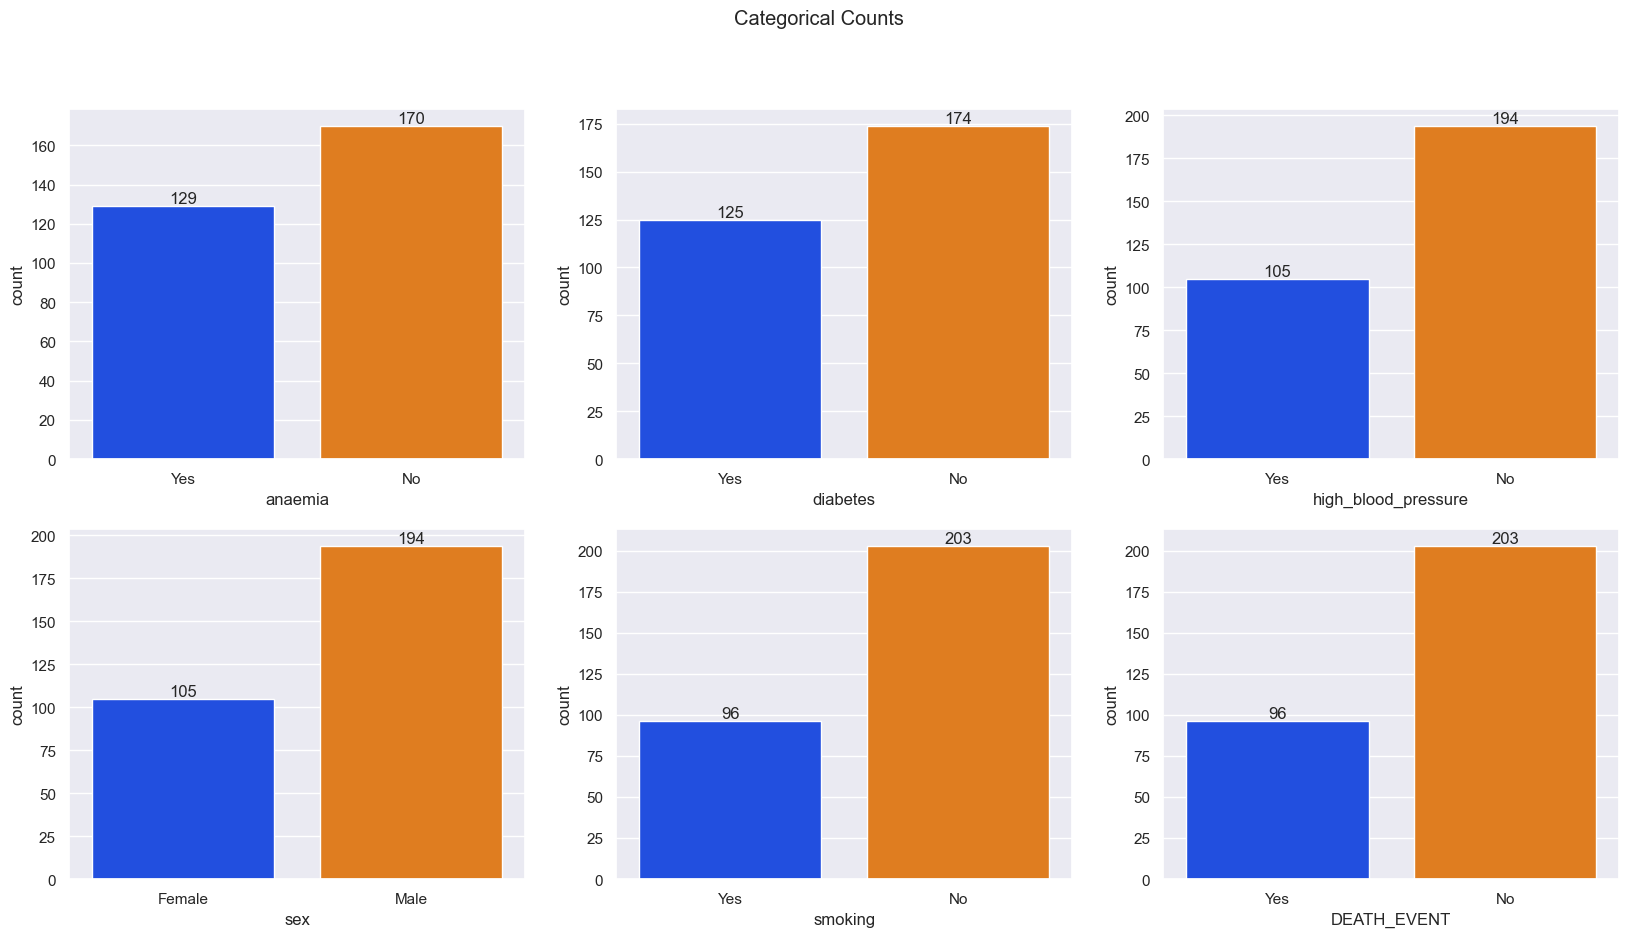

In [13]:
# Visualization of Categorical Columns
categoricalVisualizations(figsize=(20,10),             # Figures (Width,Height)         
                          title='Categorical Counts',  # Title of Figure                     
                          rows=2,                      # Amount of rows   
                          columns=3,                   # Amount of columns     
                          dataFrame=df_cat,            # DataFrame         
                          cat_columns=cat_columns)     # Categorical Columns  

Categorical Column Observations-
* anaemia
    - This column has the smallest difference between the two values.
<br></br>
* diabetes
    - This column has the smallest difference between the two values.
<br></br>
* high_blood_pressure
    - There seems to be more than 40% more people not having high blood pressure than having high blood pressure.
<br></br>
* sex
    - There seems are over 45% more Male cases than Female cases in this dataset.
<br></br>
* smoking
    - There is a significant amount of people that don't smoke rather than do smoke. 
<br></br>
* DEATH_EVENT
    - There seems to be more than double none deaths than death events. This could cause an issue in our final data set. There might need to be random sampling done later.

### BiVariate Analysis

Text(0.5, 1.0, 'Continuous Variable Correlations')

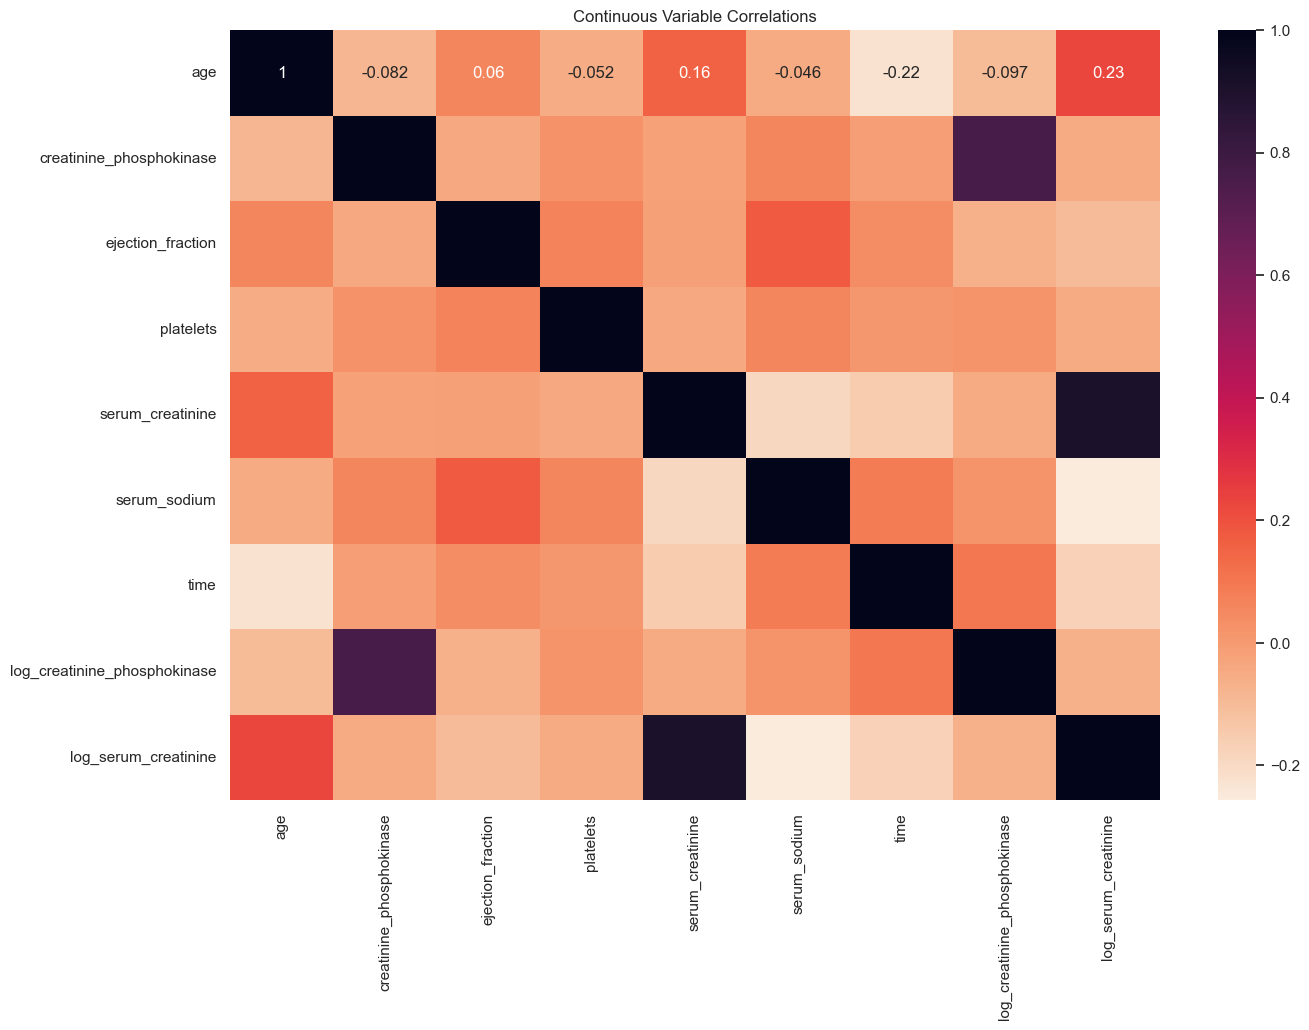

In [14]:
# Create heatmap correlations

# Set size of chart
plt.figure(figsize=(15,10))

# Create Heatmap
sns.heatmap(df[con_columns].corr(),          # Correlation chart
            annot=True,         # Add correlation value in each box
            cmap="rocket_r")    # Add color palette

# Set title of chart
plt.title('Continuous Variable Correlations')

Heatmap Correlation Observations-
* There are not correlations that are strong between any columns.
* The only strong correlations seem to be the ones that are log transformed to their non-log transformed counterparts.

#### Categorical Analysis

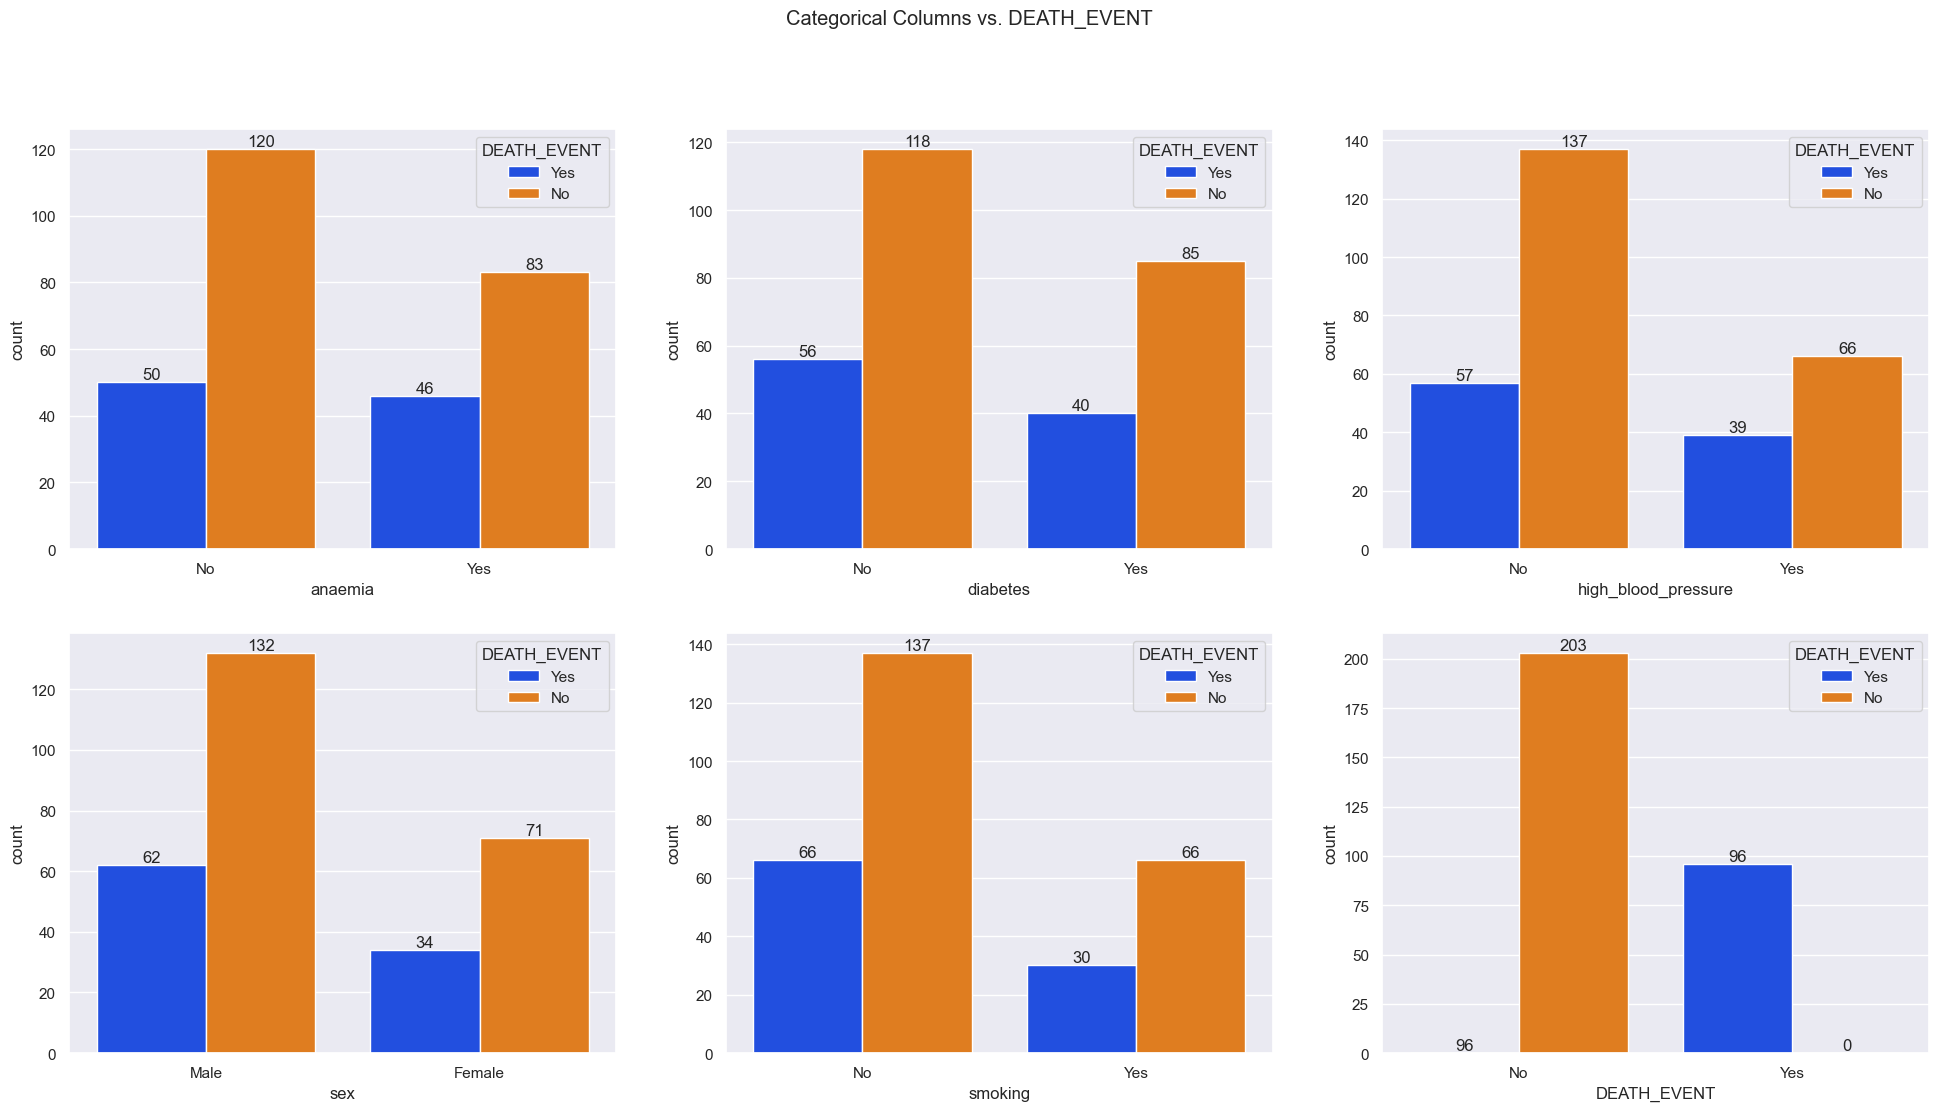

In [15]:
# Choose Size of Chart
plt.figure(figsize=(24,12))
plt.suptitle('Categorical Columns vs. DEATH_EVENT')

# Set loop value for i
i=0

# Create for loop
for col in cat_columns:
    
    # Iterate through subplots
    plt.subplot(2,3,i+1)

     # Show visualizations
    ax = sns.countplot(data=df_cat,                                       # Remapped df for categoical labels
                  x=col,                                                  # Column name
                  hue='DEATH_EVENT',                                      # Show difference color for different value for DEATH_EVENT
                  order=df_cat[col].value_counts(ascending=False).index)  # Order of values
    
    # Add Label values to chart
    yes_values = df_cat.loc[df_cat['DEATH_EVENT'] == 'Yes'][col].value_counts(ascending=False).values   # Calculate YES value counts
    no_values = df_cat.loc[df_cat['DEATH_EVENT'] == 'No'][col].value_counts(ascending=False).values     # Calculate NO value counts

    ax.bar_label(container=ax.containers[0], labels=yes_values)   # Add value counts to each bar in chart
    ax.bar_label(container=ax.containers[1], labels=no_values)    # Add value counts to each bar in chart         
    i = i+1  # Increment i by 1

Categorical Column Observations-

* anaemia
    - There does not seem to be any numbers that catch my eye.
<br></br>
* diabetes
    - There are more deaths for people who don't have diabetes than do.
<br></br>
* high_blood_pressure
    - There are more deaths for people who don't have high blood pressure than do.
<br></br>
* sex
    - There are more males death events than females. There are about 40%+ more.
<br></br>
* smoking
    - There were more deaths for people who didn't smoke than people who smoked. To be honest this one shocks me.

## Data Preprocessing

In [16]:
# Assign Data for Features and Targets
X = df.drop(columns=['DEATH_EVENT','serum_creatinine', 'creatinine_phosphokinase'])
y = df['DEATH_EVENT']

# # Scale Features 
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_array = np.array(X)

# Seperate into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 0, stratify=df['DEATH_EVENT'])

Data Preprocessing Obeservations-
* There is no need to encode any values in the dataframe.
* We dropped the traget column, and then serum_creatinine and creatinine_phosphokinase since their log transformations added more information to the dataframe than their regular columns.

## Machine Learning

#### Classification Model

In [17]:
# Machine Learning Classifiers
classifier_list = [ SVC(random_state=0),
                  GaussianNB(), 
                  XGBClassifier(random_state=0), 
                  MLPClassifier(random_state=0), 
                  LogisticRegression(random_state=0),
                  AdaBoostClassifier(random_state=0),  
                  KNeighborsClassifier(),  
                  DecisionTreeClassifier(random_state=0),       
                  RandomForestClassifier(random_state=0), 
                  QuadraticDiscriminantAnalysis()]     

 # Classifier Names
class_name = ['SVC',
               'GaussianNB', 
               'XGBClassifier',
               'MLPClassifier',
               'LogisticRegression',
               'AdaBoostClassifier',  
               'KNeighborsClassifier',  
               'DecisionTreeClassifier',       
               'RandomForestClassifier', 
               'QuadraticDiscriminantAnalysis']

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # Classification list
                  classifier_name=class_name,    # Classifier name
                  X=X,                           # X data
                  y=y,                           # Y data
                  X_train=X_train,               # X_train Dataset
                  y_train=y_train,               # y_train Dataset
                  X_test=X_test,                 # X_test Dataset
                  y_test=y_test,                 # y_test Dataset
                  kfolds=5)                      # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833
0,SVC,0.000000,0.000000,0.524984,0.000000,0.679167
3,MLPClassifier,0.000000,0.000000,0.519239,0.000000,0.679167




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
2,XGBClassifier,0.689655,0.714286,0.779254,0.701754,0.811111
1,GaussianNB,0.620690,0.782609,0.769361,0.692308,0.822222
8,RandomForestClassifier,0.689655,0.689655,0.771057,0.689655,0.800000
7,DecisionTreeClassifier,0.620690,0.750000,0.761164,0.679245,0.811111
4,LogisticRegression,0.620690,0.692308,0.744771,0.654545,0.788889
5,AdaBoostClassifier,0.620690,0.666667,0.736574,0.642857,0.777778
9,QuadraticDiscriminantAnalysis,0.586207,0.629630,0.711136,0.607143,0.755556
6,KNeighborsClassifier,0.206897,0.545455,0.562465,0.300000,0.688889
0,SVC,0.000000,0.000000,0.500000,0.000000,0.677778
3,MLPClassifier,0.000000,0.000000,0.500000,0.000000,0.677778


Classification Metrics Obeservations-
* We can see that our scores overall are not too great. The Test scores seem to be good and solid. However when doing a further analysis with cross validation we can see that our scores are just at .804 accuracy and .74 F1-score.
* Our top 3 classifiers are Logisitic Regression, GaussianNB, Quadratic Discriminant Analysis.
* The reason we are going with the models that are in the cross validation section is because cross validation gives a better overall accuracy for what the classifier predicts. Showing in turn, more accurate results.

#### Model Analysis

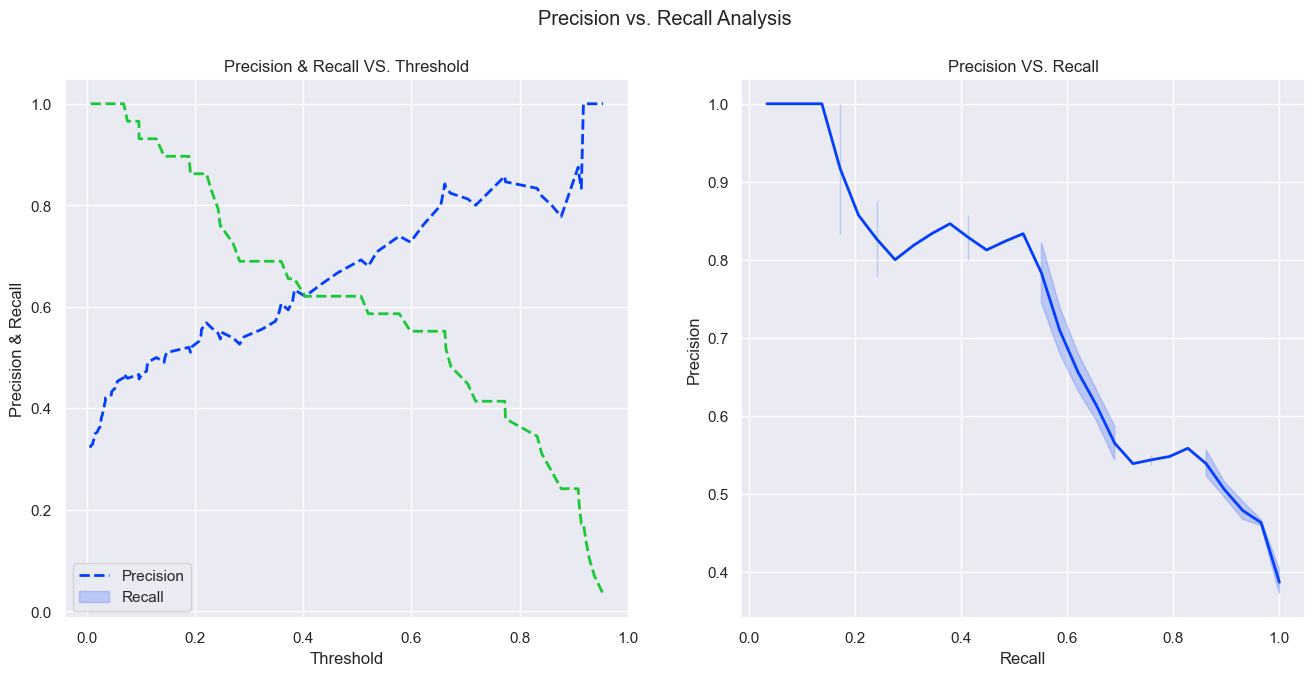

In [18]:
# Train and Predict model
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train, y_train)
y_proba = log_model.predict_proba(X_test)

# Visualize Pecision & Recall 
precisionRecallAnalysis(y_test, y_proba)

Precision & Recall Analysis Obeservations-
* We can see that the optimal threshold is right about .4 to optimize precision and recall.

#### Hypertuning

In [19]:
# Logisitic Regression Parameteres
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty': ['none', 'l2']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'max_iter': [10,100, 1000]},
              {'random_state': [0,3,5,10,15]}]

# Define Parameters for optimization
optimized_model = GridSearchCV(estimator=log_model,     # Final machine learning model to optimize 
                               param_grid=parameters,   # List of parameters for machine learning model
                               scoring = 'f1',          # Scoring for classification
                               cv=5,                    # Rounds of training for each parameter combo
                               n_jobs=-1)               # Number of CPU threads to use. We are using all avialble here.

# Optmize model Train and Prediction
optimized_model.fit(X_train, y_train)

# Add this model to classifier list
classifier_list.append(optimized_model)
class_name.append('Optimized Logistic Regression')

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,
                  classifier_name=class_name,
                  X=X,                  # X data
                  y=y,                  # Y data
                  X_train=X_train,      # X_train Dataset
                  y_train=y_train,      # y_train Dataset
                  X_test=X_test,        # X_test Dataset
                  y_test=y_test,        # y_test Dataset
                  kfolds=5)             # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833
0,SVC,0.000000,0.000000,0.524984,0.000000,0.679167




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
10,Optimized Logistic Regression,0.655172,0.863636,0.802996,0.745098,0.855556
2,XGBClassifier,0.689655,0.714286,0.779254,0.701754,0.811111
1,GaussianNB,0.620690,0.782609,0.769361,0.692308,0.822222
8,RandomForestClassifier,0.689655,0.689655,0.771057,0.689655,0.800000
7,DecisionTreeClassifier,0.620690,0.750000,0.761164,0.679245,0.811111
4,LogisticRegression,0.620690,0.692308,0.744771,0.654545,0.788889
5,AdaBoostClassifier,0.620690,0.666667,0.736574,0.642857,0.777778
9,QuadraticDiscriminantAnalysis,0.586207,0.629630,0.711136,0.607143,0.755556
6,KNeighborsClassifier,0.206897,0.545455,0.562465,0.300000,0.688889
0,SVC,0.000000,0.000000,0.500000,0.000000,0.677778


Hypertuning Observations-
* We can see that there was no increase in our F1 score. So this model does not out perfrom the default Logistic Regression model.
* We can see that there was an increase in the test scores. But this is not what we are going to evaluate our model on. The cross validation is more accurate in terms of metrics.
* Next we are going to build a ensemble model of the top 3 classifiers to increase our scores.

#### Feature Importance

   Logisitic Regression Feature Importance
----------------------------------------


,Feature,Scoring
3,ejection_fraction,0.085949
0,age,0.050826
9,time,0.020525
6,serum_sodium,0.014060
10,log_creatinine_phosphokinase,0.003833
11,log_serum_creatinine,0.003502
1,anaemia,0.000576
8,smoking,0.000519
7,sex,0.000160
4,high_blood_pressure,0.000150


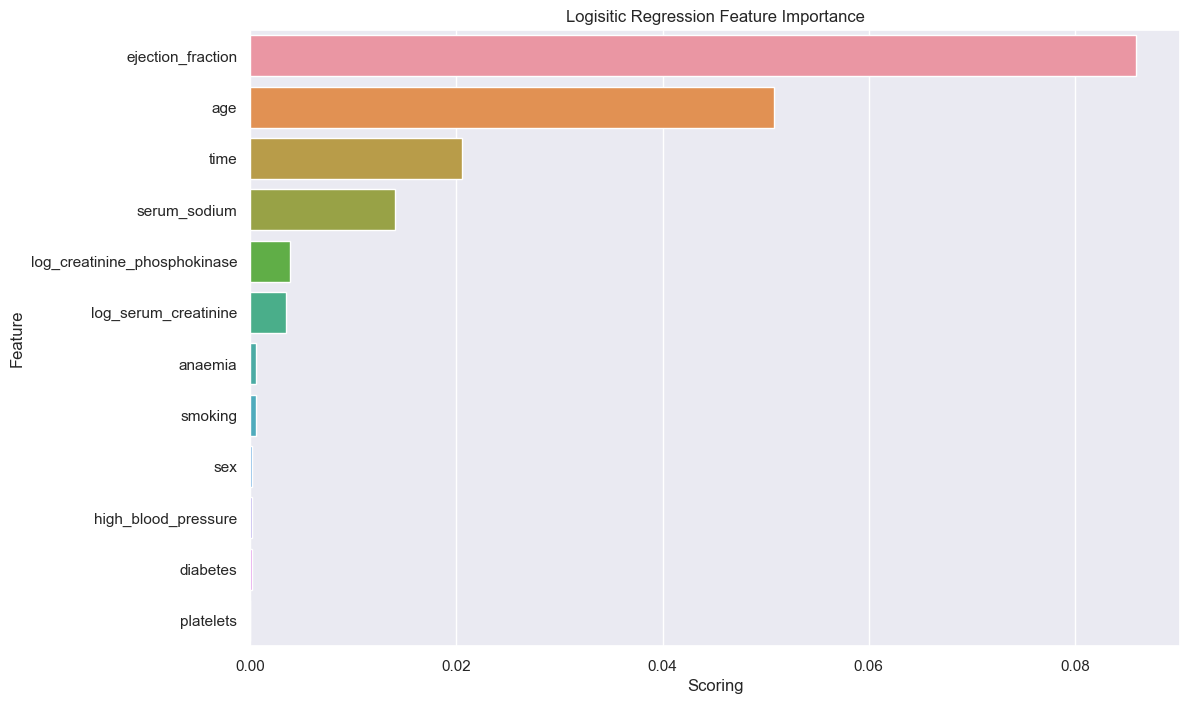

In [20]:
# Logisitic Regression Feature Importance
logisticRegressionImportance(model=LogisticRegression(random_state=0),   # Logisitc Regression Model
                             X=X,                                        # X dataset
                             X_train=X_train,                            # X_train dataset
                             y_train=y_train)                            # y_train dataset

Feature Importance Obersvations-
* We can see that the ejection_fraction have the highest importance when it comes to predicting heartfailure. 
* The second is age.
* Platelet count have almost no effect on heart failure and neither does smoking.
* I do believe that this model represents what would be significant in to most doctors to predicting heart failure.

### Ensemble Model

In [21]:
# Top 3 Classifiers in Results Testing
voting_clf = VotingClassifier(estimators=[ ('Optimized Logisitic Regression',optimized_model),            # 1 Classifier
                                           ('Logistic Regression', LogisticRegression(random_state=0)),   # 2 Classifier
                                           ('GaussianNB',GaussianNB())])                                  # 3 Classifier

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Change Classification to Soft for prediction Probabilties
voting_clf.voting = 'soft'

# Add this model to classifier list
classifier_list.append(voting_clf)
class_name.append('Voting Classifier')

# Run Classification Metrics on all created models
classifierMetrics(classifiers=classifier_list,
                  classifier_name=class_name,
                  X=X,                # X data
                  y=y,                # Y data
                  X_train=X_train,    # X_train Dataset
                  y_train=y_train,    # y_train Dataset
                  X_test=X_test,      # X_test Dataset
                  y_test=y_test,      # y_test Dataset
                  kfolds=5)           # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
11,Voting Classifier,0.776316,0.772529,0.956209,0.727372,0.800000
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167
5,AdaBoostClassifier,0.539474,0.413856,0.612172,0.422904,0.600000
6,KNeighborsClassifier,0.167763,0.333333,0.504586,0.216863,0.645833




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
10,Optimized Logistic Regression,0.655172,0.863636,0.802996,0.745098,0.855556
2,XGBClassifier,0.689655,0.714286,0.779254,0.701754,0.811111
1,GaussianNB,0.620690,0.782609,0.769361,0.692308,0.822222
11,Voting Classifier,0.620690,0.782609,0.769361,0.692308,0.822222
8,RandomForestClassifier,0.689655,0.689655,0.771057,0.689655,0.800000
7,DecisionTreeClassifier,0.620690,0.750000,0.761164,0.679245,0.811111
4,LogisticRegression,0.620690,0.692308,0.744771,0.654545,0.788889
5,AdaBoostClassifier,0.620690,0.666667,0.736574,0.642857,0.777778
9,QuadraticDiscriminantAnalysis,0.586207,0.629630,0.711136,0.607143,0.755556
6,KNeighborsClassifier,0.206897,0.545455,0.562465,0.300000,0.688889


Ensemble Testing Obeservations-
* We can see with this model, it slightly under perfoms in the cross-validation when comparing this to Logisitic regression.

####  Ensemble Precision & Recall

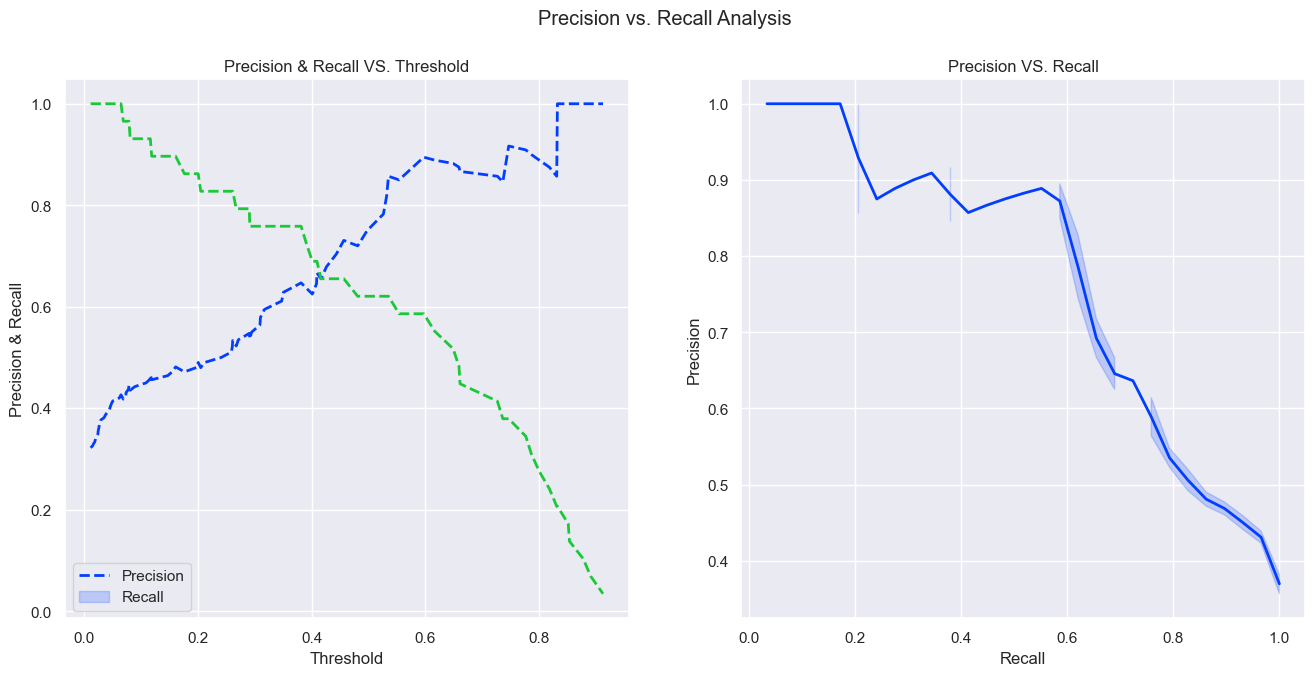

In [22]:
# Predict Probabilities for X_test
y_proba2 = voting_clf.predict_proba(X_test)

# Visualize Pecision & Recall 
precisionRecallAnalysis(y_test, y_proba2)

Ensemble Precision & Recall Observations-
* We can see that tht optimal threshold is just above 0.4. 

### Resampling Dataset

In [23]:
# Show Value Counts
display(round(df['DEATH_EVENT'].value_counts() / len(df)  * 100, 1))

DEATH_EVENT
0    67.9
1    32.1
Name: count, dtype: float64

Resampling Observations-
* We can see that we don't need to have resampling done to this dataframe. But I decided to experiment and see how this would come out.

In [24]:
# Resample the DataSet
X_resamp, y_resamp = RandomOverSampler(random_state=0).fit_resample(X, y)
X_train_resamp, y_train_resamp = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
X_test_resamp, y_test_resamp = RandomOverSampler(random_state=0).fit_resample(X_test, y_test)

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # List of classifiers
                  classifier_name=class_name,    # Classifier names
                  X=X_resamp,                    # X data
                  y=y_resamp,                    # Y data
                  X_train=X_train_resamp,        # X_train Dataset
                  y_train=y_train_resamp,        # y_train Dataset
                  X_test=X_test_resamp,          # X_test Dataset
                  y_test=y_test_resamp,          # y_test Dataset
                  kfolds=5)                      # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
8,RandomForestClassifier,0.932927,0.786719,0.960236,0.838005,0.800775
5,AdaBoostClassifier,0.951067,0.724136,0.867705,0.814797,0.769874
2,XGBClassifier,0.951220,0.719034,0.893003,0.811858,0.766749
7,DecisionTreeClassifier,0.945122,0.702400,0.747790,0.798723,0.748231
10,Optimized Logistic Regression,0.792226,0.791031,0.878209,0.758187,0.757189
11,Voting Classifier,0.810518,0.774373,0.888147,0.749554,0.726777
1,GaussianNB,0.798171,0.777785,0.862928,0.748378,0.726777
9,QuadraticDiscriminantAnalysis,0.767835,0.751467,0.849684,0.736966,0.732535
4,LogisticRegression,0.785823,0.767609,0.885128,0.719230,0.702160
6,KNeighborsClassifier,0.638262,0.612607,0.653995,0.623781,0.612466




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
10,Optimized Logistic Regression,0.754098,0.793103,0.778689,0.773109,0.778689
8,RandomForestClassifier,0.672131,0.836735,0.770492,0.745455,0.770492
11,Voting Classifier,0.688525,0.763636,0.737705,0.724138,0.737705
9,QuadraticDiscriminantAnalysis,0.704918,0.728814,0.721311,0.716667,0.721311
2,XGBClassifier,0.639344,0.812500,0.745902,0.715596,0.745902
1,GaussianNB,0.639344,0.735849,0.704918,0.684211,0.704918
5,AdaBoostClassifier,0.590164,0.800000,0.721311,0.679245,0.721311
4,LogisticRegression,0.622951,0.703704,0.680328,0.660870,0.680328
7,DecisionTreeClassifier,0.491803,0.833333,0.696721,0.618557,0.696721
6,KNeighborsClassifier,0.442623,0.509434,0.508197,0.473684,0.508197


ReSampling Obeservations-
* Resampling was applied and we can see an increase in F1-score which is great.
* We see a slight decrease in accuracy, but when we compare our results to the testing results we can see that there is a smaller difference between the values. So this is something that is great. 

##### Ensemble Random Sampling

In [25]:
# Top 3 Classifiers in Results Testing
voting_clf_resampled = VotingClassifier(estimators=[ ('Random Forest', RandomForestClassifier(random_state=0)),   # 1 Classifier
                                                     ('ADA Boost', AdaBoostClassifier(random_state=0)),           # 2 Classifier
                                                     ('XGB', XGBClassifier(random_state=0))])                     # 3 Classifier

# Train Voting Classifier
voting_clf_resampled.fit(X_train, y_train)

# Change Classification to Soft for prediction Probabilties
voting_clf_resampled.voting = 'soft'

# Add this model to classifier list
classifier_list.append(voting_clf_resampled)
class_name.append('Resampled Voting Classifier')

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # List of classifiers
                  classifier_name=class_name,    # Classifier names
                  X=X_resamp,                   # X data
                  y=y_resamp,                   # Y data
                  X_train=X_train_resamp,       # X_train Dataset
                  y_train=y_train_resamp,       # y_train Dataset
                  X_test=X_test_resamp,         # X_test Dataset
                  y_test=y_test_resamp,         # y_test Dataset
                  kfolds=5)                     # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
8,RandomForestClassifier,0.932927,0.786719,0.960236,0.838005,0.800775
12,Resampled Voting Classifier,0.957317,0.745118,0.950219,0.829605,0.788392
5,AdaBoostClassifier,0.951067,0.724136,0.867705,0.814797,0.769874
2,XGBClassifier,0.951220,0.719034,0.893003,0.811858,0.766749
7,DecisionTreeClassifier,0.945122,0.702400,0.747790,0.798723,0.748231
10,Optimized Logistic Regression,0.792226,0.791031,0.878209,0.758187,0.757189
11,Voting Classifier,0.810518,0.774373,0.888147,0.749554,0.726777
1,GaussianNB,0.798171,0.777785,0.862928,0.748378,0.726777
9,QuadraticDiscriminantAnalysis,0.767835,0.751467,0.849684,0.736966,0.732535
4,LogisticRegression,0.785823,0.767609,0.885128,0.719230,0.702160




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
10,Optimized Logistic Regression,0.754098,0.793103,0.778689,0.773109,0.778689
8,RandomForestClassifier,0.672131,0.836735,0.770492,0.745455,0.770492
11,Voting Classifier,0.688525,0.763636,0.737705,0.724138,0.737705
9,QuadraticDiscriminantAnalysis,0.704918,0.728814,0.721311,0.716667,0.721311
2,XGBClassifier,0.639344,0.812500,0.745902,0.715596,0.745902
12,Resampled Voting Classifier,0.606557,0.804348,0.729508,0.691589,0.729508
1,GaussianNB,0.639344,0.735849,0.704918,0.684211,0.704918
5,AdaBoostClassifier,0.590164,0.800000,0.721311,0.679245,0.721311
4,LogisticRegression,0.622951,0.703704,0.680328,0.660870,0.680328
7,DecisionTreeClassifier,0.491803,0.833333,0.696721,0.618557,0.696721


Ensemble Random Sampling Observations-
* We can see that this does perform well, but not the best. So we are going to continue with our Random Forest Classifier.

##### Hypertuned Random Sampling

In [26]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'random_state': [0,5,10],
    'max_depth': [5, 20, 50, 100],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30, 50, 150, 200]
}

# Create a based model
rf_model = RandomForestClassifier(random_state=0)

# Instantiate the grid search model
optimized_RandomForest = GridSearchCV(estimator = rf_model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           n_jobs = -1,
                           scoring='f1')

# Fit the grid search to the data
optimized_RandomForest.fit(X_train_resamp, y_train_resamp)

# Print Optimal Parameters
print('Optimized Parameters')
print(optimized_RandomForest.best_params_)

Optimized Parameters
{'max_depth': 20, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 30, 'random_state': 10}


In [27]:
# Add this model to classifier list
classifier_list.append(RandomForestClassifier(max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=150, random_state=5))
class_name.append('Optimized Resampled Random Forest')

# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # List of classifiers
                  classifier_name=class_name,    # Classifier names
                  X=X_resamp,                    # X data
                  y=y_resamp,                    # Y data
                  X_train=X_train_resamp,        # X_train Dataset
                  y_train=y_train_resamp,        # y_train Dataset
                  X_test=X_test_resamp,          # X_test Dataset
                  y_test=y_test_resamp,          # y_test Dataset
                  kfolds=5)                      # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
8,RandomForestClassifier,0.932927,0.786719,0.960236,0.838005,0.800775
12,Resampled Voting Classifier,0.957317,0.745118,0.950219,0.829605,0.788392
5,AdaBoostClassifier,0.951067,0.724136,0.867705,0.814797,0.769874
2,XGBClassifier,0.951220,0.719034,0.893003,0.811858,0.766749
13,Optimized Resampled Random Forest,0.896341,0.775645,0.943928,0.810305,0.776084
7,DecisionTreeClassifier,0.945122,0.702400,0.747790,0.798723,0.748231
10,Optimized Logistic Regression,0.792226,0.791031,0.878209,0.758187,0.757189
11,Voting Classifier,0.810518,0.774373,0.888147,0.749554,0.726777
1,GaussianNB,0.798171,0.777785,0.862928,0.748378,0.726777
9,QuadraticDiscriminantAnalysis,0.767835,0.751467,0.849684,0.736966,0.732535




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
13,Optimized Resampled Random Forest,0.754098,0.821429,0.795082,0.786325,0.795082
10,Optimized Logistic Regression,0.754098,0.793103,0.778689,0.773109,0.778689
8,RandomForestClassifier,0.672131,0.836735,0.770492,0.745455,0.770492
11,Voting Classifier,0.688525,0.763636,0.737705,0.724138,0.737705
9,QuadraticDiscriminantAnalysis,0.704918,0.728814,0.721311,0.716667,0.721311
2,XGBClassifier,0.639344,0.812500,0.745902,0.715596,0.745902
12,Resampled Voting Classifier,0.606557,0.804348,0.729508,0.691589,0.729508
1,GaussianNB,0.639344,0.735849,0.704918,0.684211,0.704918
5,AdaBoostClassifier,0.590164,0.800000,0.721311,0.679245,0.721311
4,LogisticRegression,0.622951,0.703704,0.680328,0.660870,0.680328


Hypertuning Random Sampling Observations-
* We can see that this hypertuned model does not perform better. So we will be sticking Random Forest Classification.

,Feature,Importance
9,time,0.287895
3,ejection_fraction,0.181365
11,log_serum_creatinine,0.153902
0,age,0.094015
10,log_creatinine_phosphokinase,0.078641
6,serum_sodium,0.072619
5,platelets,0.070878
8,smoking,0.014422
4,high_blood_pressure,0.013077
1,anaemia,0.012002


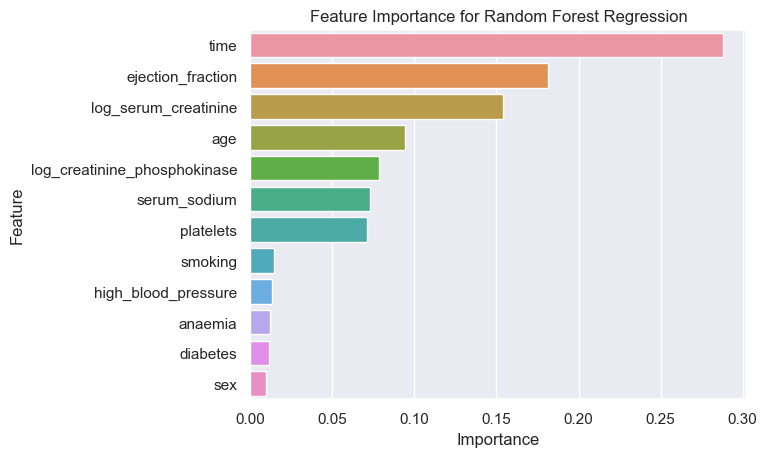

In [28]:
# Show Importance Information
treeRegressionImportance(model=RandomForestClassifier(random_state=0),   # Best performing regression model
                         X_train=X_train_resamp,                         # X_train data
                         y_train=y_train_resamp,                         # y_train data
                         model_name='Random Forest Regression')          # Name of Tree Regression model

Resampled Feature Importance Obeservaitions-
* We can see that time is the largest predictor in this model. 
* We can see that there is importance of all features in this model. There are no features that are dropping off at the end. 

## Final Model Analysis

In [29]:
# Run Classification Metrics
classifierMetrics(classifiers=classifier_list,   # Classification list
                  classifier_name=class_name,    # Classifier name
                  X=X,                           # X data
                  y=y,                           # Y data
                  X_train=X_train,               # X_train Dataset
                  y_train=y_train,               # y_train Dataset
                  X_test=X_test,                 # X_test Dataset
                  y_test=y_test,                 # y_test Dataset
                  kfolds=5)                      # of K-folds 

Cross-Validation Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
4,LogisticRegression,0.776974,0.797965,0.945542,0.736978,0.804167
11,Voting Classifier,0.776316,0.772529,0.956209,0.727372,0.800000
1,GaussianNB,0.776316,0.751079,0.963879,0.709438,0.775000
10,Optimized Logistic Regression,0.711184,0.769231,0.928044,0.684722,0.783333
13,Optimized Resampled Random Forest,0.684211,0.763387,0.882810,0.608845,0.737500
9,QuadraticDiscriminantAnalysis,0.607895,0.664236,0.797214,0.596296,0.737500
8,RandomForestClassifier,0.684211,0.596178,0.852517,0.580870,0.691667
7,DecisionTreeClassifier,0.684211,0.437078,0.650261,0.510663,0.641667
12,Resampled Voting Classifier,0.631579,0.472240,0.813888,0.502006,0.658333
2,XGBClassifier,0.618421,0.427013,0.727354,0.470040,0.629167




Train & Test Metrics


,Model,Recall,Precision,AUC,F1_Score,Accuracy
13,Optimized Resampled Random Forest,0.689655,0.833333,0.812041,0.754717,0.855556
10,Optimized Logistic Regression,0.655172,0.863636,0.802996,0.745098,0.855556
12,Resampled Voting Classifier,0.724138,0.724138,0.796495,0.724138,0.822222
2,XGBClassifier,0.689655,0.714286,0.779254,0.701754,0.811111
1,GaussianNB,0.620690,0.782609,0.769361,0.692308,0.822222
11,Voting Classifier,0.620690,0.782609,0.769361,0.692308,0.822222
8,RandomForestClassifier,0.689655,0.689655,0.771057,0.689655,0.800000
7,DecisionTreeClassifier,0.620690,0.750000,0.761164,0.679245,0.811111
4,LogisticRegression,0.620690,0.692308,0.744771,0.654545,0.788889
5,AdaBoostClassifier,0.620690,0.666667,0.736574,0.642857,0.777778


Final Observations-
* We can see that the best performing model is Random Forest Classification with Random Sampling.
* After giving consideration to the feature importance, I have not chosen this model as the final model.
* The Final model will be Logistic Regression. This is because there is a very small amount of difference in accuracy between these two models. Also when it comes to acutal methods, these parameters for importance see to correlate with real life considerations.
* That is why the final model will be a Logistic Regression classifier.

#### Save Model for further predictions

In [30]:
# Fit final model
final_model = LogisticRegression(random_state=0)
final_model.fit(X,y)

# Save model as pickle for further use
pd.to_pickle(final_model, './Heart_Failure_Model.pickle')

In [31]:
print(X.columns)
heart_failure_model = pd.read_pickle('./Heart_Failure_Model.pickle')
result = heart_failure_model.predict([[85,0,0,20, 1, 260000, 136, 1, 0, 112, np.log(580), np.log(1.38)]])
probability = heart_failure_model.predict_proba([[85,0,0,20, 1, 260000, 136, 1, 0, 112, np.log(580), np.log(2.38)]])
print(result)
print(probability[0][1])

Index(['age', 'anaemia', 'diabetes', 'ejection_fraction',
       'high_blood_pressure', 'platelets', 'serum_sodium', 'sex', 'smoking',
       'time', 'log_creatinine_phosphokinase', 'log_serum_creatinine'],
      dtype='object')
[1]
0.8252804263829474


   Logisitic Regression Feature Importance
----------------------------------------


,Feature,Scoring
3,ejection_fraction,0.069784
0,age,0.048569
9,time,0.019921
6,serum_sodium,0.009653
10,log_creatinine_phosphokinase,0.003962
11,log_serum_creatinine,0.003292
8,smoking,0.000265
2,diabetes,0.000236
4,high_blood_pressure,0.000117
7,sex,0.000090


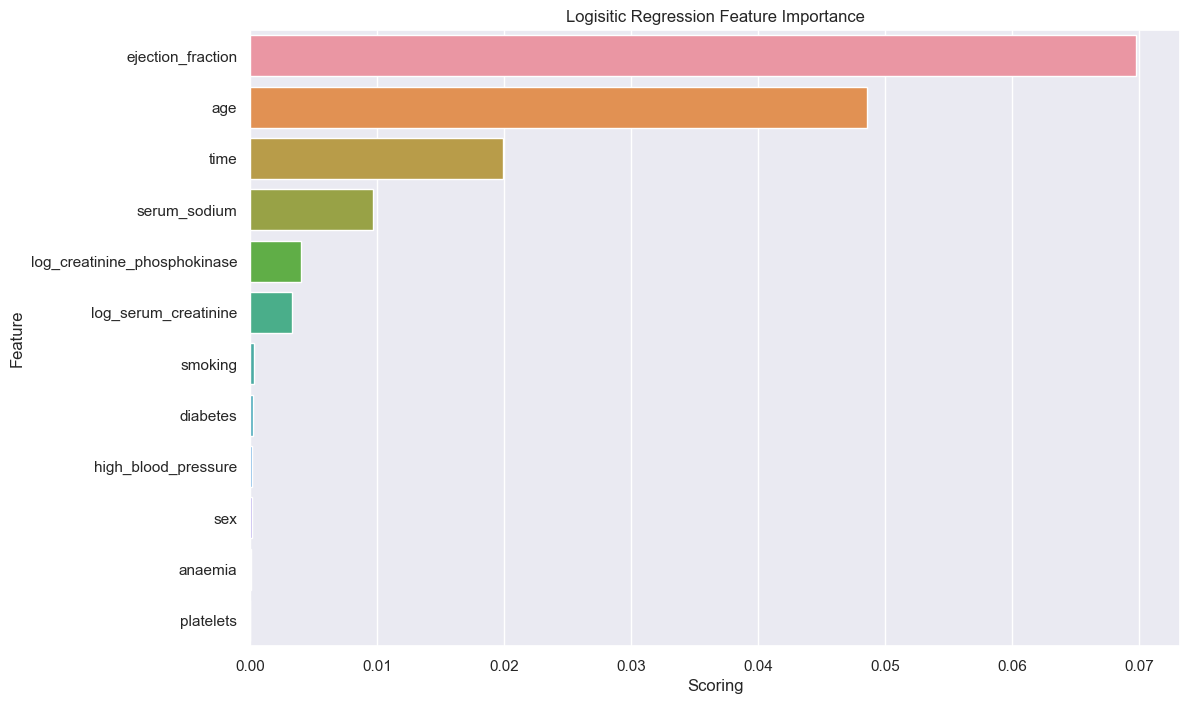

In [32]:
# Logisitic Regression Feature Importance
logisticRegressionImportance(model=LogisticRegression(random_state=0),   # Logisitc Regression Model
                         X=X,                                        # X dataset
                         X_train=X,                                  # X_train dataset
                         y_train=y)                                  # y_train dataset

<h4> Importance Analysis </h4>
<ul>
    <li> After running our Logisitic Regression Calculations, we can find that the most imporant feature of this dataset it the ejection Fraciton.</li>
    <li> We can see that the bottom 4 features add almost nothing to the dataset.</li>

</ul>